In [1]:
import casadi as ca
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Bezier:

    def __init__(self, P: ca.SX, T: float):
        self.P = P
        self.m = P.shape[0]
        self.n = P.shape[1]-1
        self.T = T
    
    def bernstein(self, i, t):
        return binom(self.n, i)*t**i*(1 - t)**(self.n-i)
        
    def eval(self, t):
        beta = t/self.T
        s = ca.SX.zeros(self.m, 1)
        for i in range(self.n+1):
            s += self.bernstein(i, beta)*self.P[:, i]
        return s
    
    def deriv(self, m=1):
        D = ca.SX(self.P)
        for j in range(0, m):
            D = (self.n - j)*ca.horzcat(*[ D[:, i+1] - D[:, i] for i in range(self.n - j) ])
        return Bezier(D/self.T**m, self.T)

In [3]:
def derive_bezier_6():
    n = 6
    T = ca.SX.sym('T')
    t = ca.SX.sym('t')
    P = ca.SX.sym('P', 1, n)
    B = Bezier(P, T)

    # derivatives
    B_d = B.deriv()
    B_d2 = B_d.deriv()
    B_d3 = B_d2.deriv()
    B_d4 = B_d3.deriv()

    # boundary conditions

    # trajectory
    p = B.eval(t)
    v = B_d.eval(t)
    a = B_d2.eval(t)
    r = ca.vertcat(p, v, a)

    # given position/velocity boundary conditions, solve for bezier points
    wp_0 = ca.SX.sym('p0', 2, 1)  # pos/vel at waypoint 0
    wp_1 = ca.SX.sym('p1', 2, 1)  # pos/vel at waypoint 1

    constraints = []
    constraints += [(B.eval(0), wp_0[0])]  # pos @ wp0
    constraints += [(B_d.eval(0), wp_0[1])]  # vel @ wp0
    constraints += [(B_d2.eval(0), 0)]  # zero accel @ wp0
    constraints += [(B.eval(T), wp_1[0])]  # pos @ wp1
    constraints += [(B_d.eval(T), wp_1[1])]  # vel @ wp1
    constraints += [(B_d2.eval(T), 0)]  # zero accel @ wp1

    assert len(constraints) == 6

    Y = ca.vertcat(*[c[0] for c in constraints])
    b = ca.vertcat(*[c[1] for c in constraints])
    A = ca.jacobian(Y, P)
    A_inv = ca.inv(A)
    P_sol = (A_inv@b).T
    return {
        'solve_pos_vel': ca.Function('bezier_solve', [wp_0, wp_1, T], [P_sol], ['wp_0', 'wp_1', 'T'], ['P']),
        'traj': ca.Function('bezier_traj', [t, T, P], [r], ['t', 'T', 'P'], ['r']),
    }

In [4]:
bezier_6 = derive_bezier_6()
T0 = 1
wp_0 = [0, 0]  # pos/vel at waypoint 0
wp_1 = [1, 0]  # pos/vel at waypoint 1
P0 = bezier_6['solve_pos_vel'](wp_0, wp_1, T0)
P0

DM([[0, 0, 0, 1, 1, 1]])

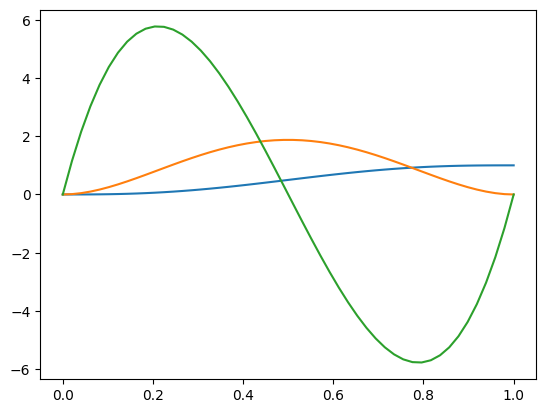

In [5]:
t0 = np.linspace(0, T0)
x = np.array(bezier_6['traj'](np.array([t0]), T0, P0))
plt.plot(t0, x.T);

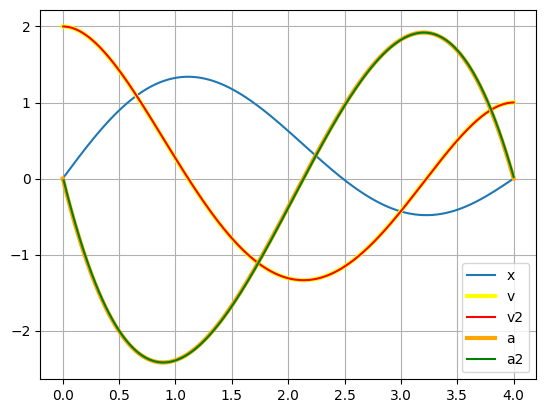

In [6]:
# check bezier with numerical derivatives
def check_bezier():
    bezier_6 = derive_bezier_6()
    T0 = 4
    P0 = bezier_6['solve_pos_vel']([0, 2], [0, 1], T0)
    B0 = Bezier(P0, T0)
    t = np.linspace(0, T0, 1000)
    x = np.array(ca.DM(B0.eval(t))).reshape(-1)
    v = ca.DM(B0.deriv(1).eval(t))
    a = ca.DM(B0.deriv(2).eval(t))
    v2 = np.diff(x.reshape(-1), axis=0)/np.diff(t, axis=0)
    a2 = np.diff(v2.reshape(-1), axis=0)/np.diff(t[1:], axis=0)

    plt.plot(t, x, label='x')
    plt.plot(t, v, label='v', linewidth=3, color='yellow')
    plt.plot(t[1:], v2, label='v2', color='red')
    plt.plot(t, a, label='a', color='orange', linewidth=3)
    plt.plot(t[2:], a2, label='a2', color='green')
    plt.legend()
    plt.grid()

check_bezier()

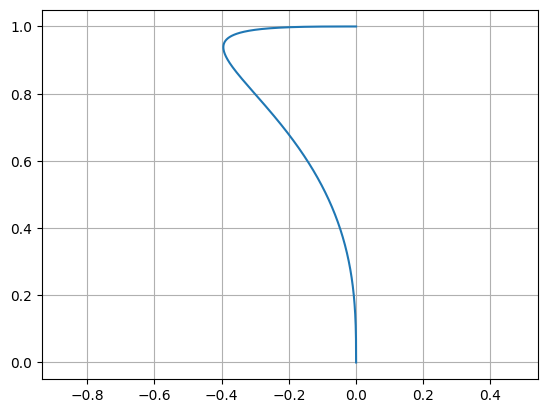

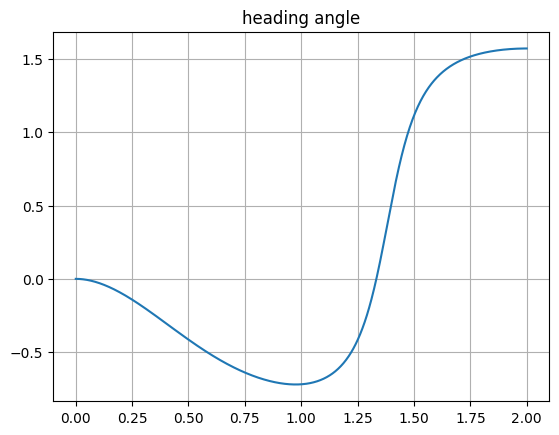

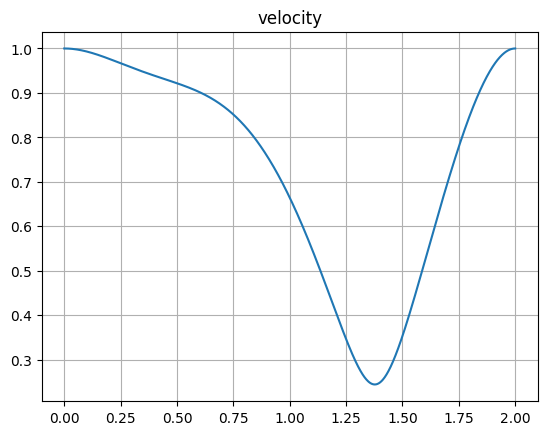

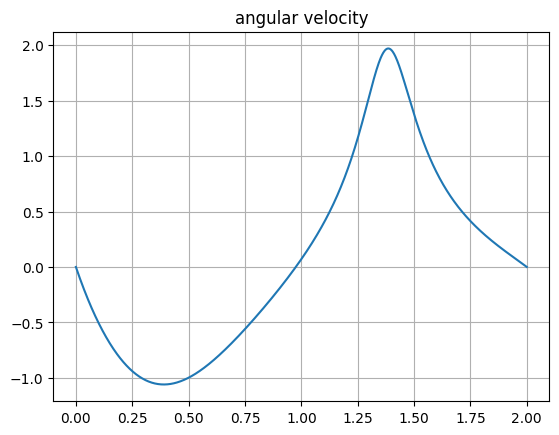

In [7]:
def rover_plan():
    T0 = 2
    bezier_6 = derive_bezier_6()

    bc = np.array([
        [ # position
            [0, 0],  # wp0, x, y
            [1, 0]   # wp1, x, y
        ],
        [ # velocity
            [1, 0],
            [0, 1]
        ]
    ])


    t0 = np.linspace(0, T0, 1000)
    PX = bezier_6['solve_pos_vel'](bc[:, 0, 0], bc[:, 1, 0], T0)
    traj_x = np.array(bezier_6['traj'](np.array([t0]), T0, PX)).T

    PY = bezier_6['solve_pos_vel'](bc[:, 0, 1], bc[:, 1, 1], T0)
    traj_y = np.array(bezier_6['traj'](np.array([t0]), T0, PY)).T

    x = traj_x[:, 0]
    vx = traj_x[:, 1]
    ax = traj_x[:, 2]

    y = traj_y[:, 0]
    vy = traj_y[:, 1]
    ay = traj_y[:, 2]


    psi = np.arctan2(vy, vx)
    V = np.sqrt(vx**2 + vy**2)
    omega = (vx*ay - vy*ax)/V

    if True:

        plt.plot(y, x)
        plt.axis('equal');
        plt.grid()

        plt.figure()
        plt.title('heading angle')
        plt.plot(t0, psi)
        plt.grid()

        plt.figure()
        plt.title('velocity')
        plt.plot(t0, V)
        plt.grid()

        plt.figure()
        plt.title('angular velocity')
        plt.plot(t0, omega)
        plt.grid()

rover_plan()